# preparing environment and data.

In [1]:
pip install gensim

In [12]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from collections import Counter
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # Для визуализации, если t-SNE слишком сложен для начала

# Загрузка необходимых ресурсов NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') # Для POS-теггинга
nltk.download('tagsets') # Для help.upenn_tagset
nltk.download('punkt_tab') # Эту строку нужно добавить
nltk.download('averaged_perceptron_tagger_eng') # Эту строку нужно добавить
nltk.download('tagsets_json') # Эту строку нужно добавить

# Загрузка spaCy модели
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading spacy model 'en_core_web_sm'...")
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Исходные данные
data = {
    'Review': [
        'At McDonald\'s the food was ok and the service was bad.',
        'I would not recommend this Japanese restaurant to anyone.',
        'I loved this restaurant when I traveled to Thailand last summer.',
        'The menu of Loving has a wide variety of options.',
        'The staff was friendly and helpful at Google\'s employees restaurant.',
        'The ambiance at Bella Italia is amazing, and the pasta dishes are delicious.',
        'I had a terrible experience at Pizza Hut. The pizza was burnt, and the service was slow.',
        'The sushi at Sushi Express is always fresh and flavorful.',
        'The steakhouse on Main Street has a cozy atmosphere and excellent steaks.',
        'The dessert selection at Sweet Treats is to die for!'
    ]
}
df = pd.DataFrame(data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagse

# Exercise 1: Exploring Text Preprocessing usage, NER and POS tags

# 1. preprocess_text() function

This function implements the first stage of our NLP pipeline - preprocessing.

In [5]:
def preprocess_text(text_data):
    processed_strings = []
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    for text in text_data['Review']:
        # 1. Lowercase and tokenize
        # Убираем пунктуацию на этом же шаге, чтобы не мешала токенизации и дальнейшей обработке.
        # Просто оставляем только буквенные символы и цифры, затем токенизируем
        # Более правильный подход - сначала токенизировать, потом убирать пунктуацию из токенов
        tokens = word_tokenize(text.lower())

        # Убираем пунктуацию из токенов и фильтруем неалфавитные символы
        cleaned_tokens = [word for word in tokens if word.isalpha()]

        # 2. Remove stopwords
        filtered_words = [word for word in cleaned_tokens if word not in stop_words]

        # 3. Apply lemmatizer
        lemmas = [lemmatizer.lemmatize(word) for word in filtered_words]

        # Return the preprocessed string (joined back) or list of tokens
        # Для Word2Vec лучше возвращать список токенов, а не соединенную строку.
        # Для других задач можно и строку. В данном случае, вернем список токенов.
        processed_strings.append(lemmas)

    return processed_strings

# Применяем функцию и печатаем результат для проверки
preprocessed_reviews_tokens = preprocess_text(df)
print("Preprocessed (tokenized) Reviews Sample:")
for i, review in enumerate(preprocessed_reviews_tokens[:3]): # Печатаем первые 3 для краткости
    print(f"Review {i+1}: {review}")
print("-" * 30)

Preprocessed (tokenized) Reviews Sample:
Review 1: ['mcdonald', 'food', 'ok', 'service', 'bad']
Review 2: ['would', 'recommend', 'japanese', 'restaurant', 'anyone']
Review 3: ['loved', 'restaurant', 'traveled', 'thailand', 'last', 'summer']
------------------------------


# 2. Create a new dataset with the cleaned text

We've already got the preprocessed texts as a list of token lists (preprocessed_reviews_tokens). Now let's create a new DataFrame to store them alongside the original data.

In [6]:
df_cleaned = df.copy()
# Сохраняем предобработанные токены
df_cleaned['Preprocessed_Tokens'] = preprocessed_reviews_tokens
# Если нужна соединенная строка для других целей:
df_cleaned['Preprocessed_Text'] = [' '.join(tokens) for tokens in preprocessed_reviews_tokens]

print("Original and Preprocessed Data Sample:")
print(df_cleaned[['Review', 'Preprocessed_Text']].head())
print("-" * 30)

Original and Preprocessed Data Sample:
                                              Review  \
0  At McDonald's the food was ok and the service ...   
1  I would not recommend this Japanese restaurant...   
2  I loved this restaurant when I traveled to Tha...   
3  The menu of Loving has a wide variety of options.   
4  The staff was friendly and helpful at Google's...   

                                   Preprocessed_Text  
0                       mcdonald food ok service bad  
1         would recommend japanese restaurant anyone  
2     loved restaurant traveled thailand last summer  
3                    menu loving wide variety option  
4  staff friendly helpful google employee restaurant  
------------------------------


3. perform_ner() function

Using SpaCy for Named Entity Recognition (NER).

In [7]:
def perform_ner(text):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        entities.append({"text": ent.text, "label": ent.label_})
    return entities

# Применяем NER к исходным данным и к предобработанным, чтобы увидеть разницу
df['NER_Raw'] = df['Review'].apply(perform_ner)
df_cleaned['NER_Preprocessed'] = df_cleaned['Preprocessed_Text'].apply(perform_ner)

print("\nNER on Raw Data Sample:")
for i, ner_output in enumerate(df['NER_Raw'].head(3)):
    print(f"Review {i+1}: {ner_output}")

print("\nNER on Preprocessed Data Sample (might be less effective due to info loss):")
for i, ner_output in enumerate(df_cleaned['NER_Preprocessed'].head(3)):
    print(f"Review {i+1}: {ner_output}")
print("-" * 30)


NER on Raw Data Sample:
Review 1: [{'text': 'McDonald', 'label': 'ORG'}]
Review 2: [{'text': 'Japanese', 'label': 'NORP'}]
Review 3: [{'text': 'Thailand', 'label': 'GPE'}, {'text': 'last summer', 'label': 'DATE'}]

NER on Preprocessed Data Sample (might be less effective due to info loss):
Review 1: [{'text': 'mcdonald food ok service', 'label': 'ORG'}]
Review 2: [{'text': 'japanese', 'label': 'NORP'}]
Review 3: [{'text': 'thailand', 'label': 'GPE'}, {'text': 'last summer', 'label': 'DATE'}]
------------------------------


4. perform_pos_tagging() function

Using NLTK for POS tagging.

In [10]:
def perform_pos_tagging(text_tokens): # Принимает список токенов
    # pos_tag работает со списком токенов
    pos_tags = nltk.pos_tag(text_tokens)
    return pos_tags

# Применяем POS-теггинг
# Применим к предобработанным токенам (как указано в условии "receives the text as argument")
# В данном случае, это список токенов, что идеально для nltk.pos_tag
df_cleaned['POS_Preprocessed'] = df_cleaned['Preprocessed_Tokens'].apply(perform_pos_tagging)

# Также можем применить к токенам из сырых данных (для сравнения)
df['Tokens_Raw'] = df['Review'].apply(lambda x: word_tokenize(x.lower())) # Токенизируем сырые данные
df['POS_Raw'] = df['Tokens_Raw'].apply(perform_pos_tagging)


print("\nPOS Tagging on Preprocessed Tokens Sample:")
for i, pos_output in enumerate(df_cleaned['POS_Preprocessed'].head(3)):
    print(f"Review {i+1}: {pos_output}")

print("\nPOS Tagging on Raw Tokens Sample:")
for i, pos_output in enumerate(df['POS_Raw'].head(3)):
    print(f"Review {i+1}: {pos_output}")
print("-" * 30)


POS Tagging on Preprocessed Tokens Sample:
Review 1: [('mcdonald', 'NNS'), ('food', 'NN'), ('ok', 'JJ'), ('service', 'NN'), ('bad', 'JJ')]
Review 2: [('would', 'MD'), ('recommend', 'VB'), ('japanese', 'JJ'), ('restaurant', 'NN'), ('anyone', 'NN')]
Review 3: [('loved', 'VBN'), ('restaurant', 'NN'), ('traveled', 'VBN'), ('thailand', 'NN'), ('last', 'JJ'), ('summer', 'NN')]

POS Tagging on Raw Tokens Sample:
Review 1: [('at', 'IN'), ('mcdonald', 'NN'), ("'s", 'POS'), ('the', 'DT'), ('food', 'NN'), ('was', 'VBD'), ('ok', 'JJ'), ('and', 'CC'), ('the', 'DT'), ('service', 'NN'), ('was', 'VBD'), ('bad', 'JJ'), ('.', '.')]
Review 2: [('i', 'NN'), ('would', 'MD'), ('not', 'RB'), ('recommend', 'VB'), ('this', 'DT'), ('japanese', 'JJ'), ('restaurant', 'NN'), ('to', 'TO'), ('anyone', 'NN'), ('.', '.')]
Review 3: [('i', 'NN'), ('loved', 'VBD'), ('this', 'DT'), ('restaurant', 'NN'), ('when', 'WRB'), ('i', 'NN'), ('traveled', 'VBD'), ('to', 'TO'), ('thailand', 'VB'), ('last', 'JJ'), ('summer', 'NN'),

5. Output Analysis and the Importance of POS Tags

In [13]:
# Пример использования help.upenn_tagset
print("\nMeaning of 'NN' tag:")
nltk.help.upenn_tagset('NN')
print("\nMeaning of 'JJ' tag:")
nltk.help.upenn_tagset('JJ')
print("\nMeaning of 'VB' tag:")
nltk.help.upenn_tagset('VB')
print("-" * 30)


Meaning of 'NN' tag:
NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...

Meaning of 'JJ' tag:
JJ: adjective or numeral, ordinal
    third ill-mannered pre-war regrettable oiled calamitous first separable
    ectoplasmic battery-powered participatory fourth still-to-be-named
    multilingual multi-disciplinary ...

Meaning of 'VB' tag:
VB: verb, base form
    ask assemble assess assign assume atone attention avoid bake balkanize
    bank begin behold believe bend benefit bevel beware bless boil bomb
    boost brace break bring broil brush build ...
------------------------------


# **Exercise 2: Plotting the word embeddings**

1. Create the word embeddings using Word2Vec model
create embeddings. It is important to use token lists, not concatenated strings.

In [14]:
# Для Word2Vec нужны списки токенов
# Мы уже получили их в `preprocessed_reviews_tokens`
# Минимальное количество вхождений слова (min_count=1) чтобы учесть все слова в нашем маленьком датасете
# vector_size=100 - это размерность каждого вектора слова
# window=5 - размер окна контекста
# workers - количество потоков для ускорения обучения
word2vec_model = Word2Vec(sentences=preprocessed_reviews_tokens, vector_size=100, window=5, min_count=1, workers=4)

print("\nWord2Vec Model Details:")
print(f"Vocabulary size: {len(word2vec_model.wv.index_to_key)}")
print(f"Vector dimensions (vector_size): {word2vec_model.vector_size}")

# Анализ: Что такое vector_size=100?
print("\nWhat does vector_size=100 mean?")
print(f"Это означает, что каждое слово в словаре модели будет представлено 100 числами.")
print(f"Эти 100 чисел формируют вектор в 100-мерном пространстве.")
print(f"Смысл этих чисел не интерпретируется по отдельности, но вся совокупность чисел определяет 'положение' слова в этом пространстве.")
print(f"Близость векторов в этом 100-мерном пространстве указывает на семантическую или контекстуальную схожесть слов.")

# Пример вектора для слова
if 'food' in word2vec_model.wv:
    print(f"\nVector for 'food' (first 5 dimensions): {word2vec_model.wv['food'][:5]}")
else:
    print("\n'food' not in vocabulary. This can happen with very small datasets or aggressive preprocessing.")

print("-" * 30)


Word2Vec Model Details:
Vocabulary size: 55
Vector dimensions (vector_size): 100

What does vector_size=100 mean?
Это означает, что каждое слово в словаре модели будет представлено 100 числами.
Эти 100 чисел формируют вектор в 100-мерном пространстве.
Смысл этих чисел не интерпретируется по отдельности, но вся совокупность чисел определяет 'положение' слова в этом пространстве.
Близость векторов в этом 100-мерном пространстве указывает на семантическую или контекстуальную схожесть слов.

Vector for 'food' (first 5 dimensions): [-0.00696361 -0.00245851 -0.00802294  0.00750053  0.00612742]
------------------------------


2. Create a function plot_word_embeddings()

To visualize 100-dimensional vectors, we need to reduce their dimensionality to 2D. t-SNE is a good choice, but for small datasets and to get started easily, PCA (Principal Component Analysis) can be used. It is easier to use, but may not preserve local structures as well as t-SNE. Let's use PCA for simplicity, as there is no explicit requirement for t-SNE in the problem statement.

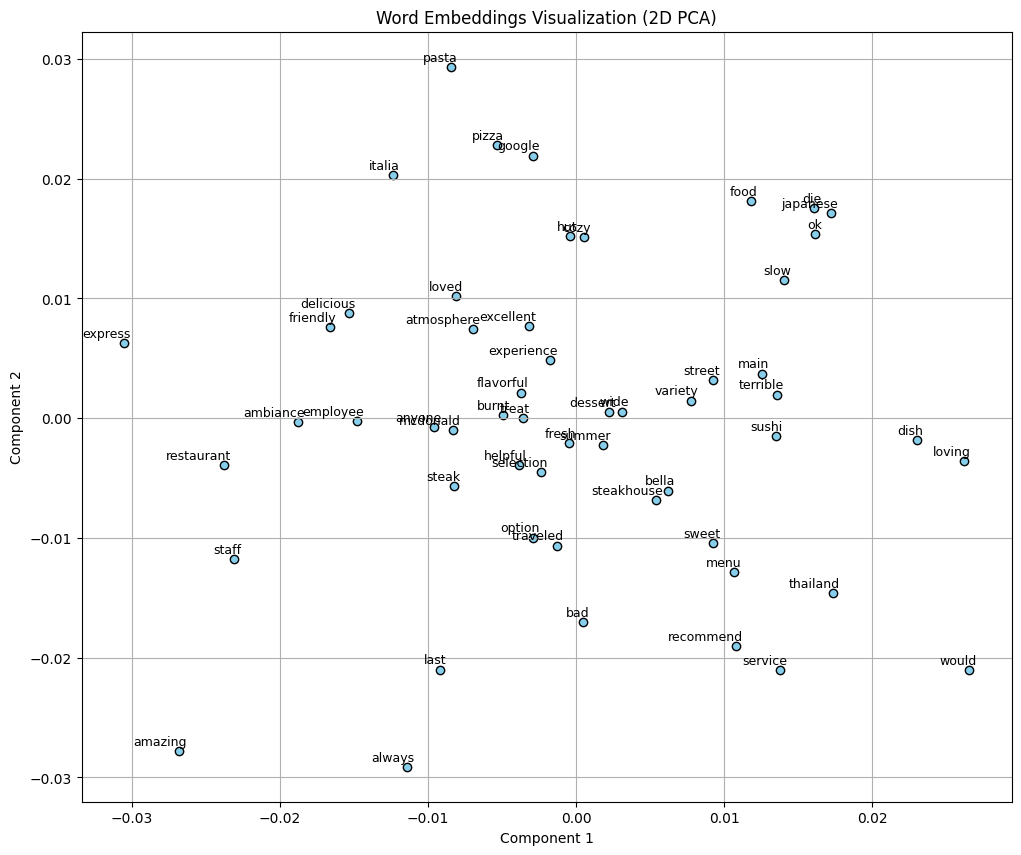

In [15]:
def plot_word_embeddings(word2vec_model):
    # Извлекаем все слова и их векторы из модели
    words = []
    vectors = []
    for word in word2vec_model.wv.index_to_key:
        words.append(word)
        vectors.append(word2vec_model.wv[word])

    # Преобразуем в numpy массив
    vectors = np.array(vectors)

    # Используем PCA для уменьшения размерности до 2D
    # t-SNE был бы лучше для визуализации кластеров, но PCA проще и стабильнее для начала
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)

    # Создаем график
    plt.figure(figsize=(12, 10))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], edgecolors='k', c='skyblue')

    # Добавляем текстовые метки к каждой точке
    for i, word in enumerate(words):
        plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom', fontsize=9)

    plt.title("Word Embeddings Visualization (2D PCA)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

# Вызываем функцию для построения графика
plot_word_embeddings(word2vec_model)